# Keras function like api

In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import numpy as np


## 1 Simple network
### 1.1 Create a network

Model: "mnist model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


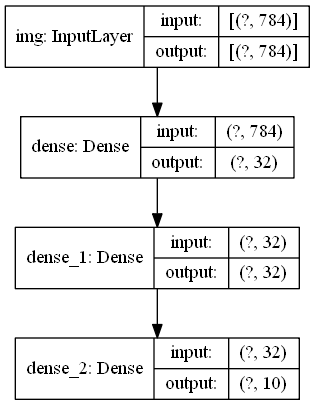

In [2]:
inputs = keras.Input(shape=(784, ), name='img')
h1 = layers.Dense(32, activation='relu')(inputs)
h2 = layers.Dense(32, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h2)
model = keras.Model(inputs=inputs, outputs=outputs, name='mnist model')

model.summary()
keras.utils.plot_model(model, 'mnist_model.png')
keras.utils.plot_model(model, 'model_info.png', show_shapes=True)


### 1.2 Train, evaluate and test

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [7]:
x_train = x_train.reshape(-1, 28*28).astype('float32')/255
x_test = x_test.reshape(-1, 28*28).astype('float32')/255


### 1.3 Save the model

In [8]:
model.save('model_save.h5')
del model
model = keras.models.load_model('model_save.h5')



In [9]:
del model

## 2. Create multiple models with shared layers

In [10]:
# Encoder and Auto-Encoder
encode_input = keras.Input(shape=(28,28,1), name='img')
h1 = layers.Conv2D(16, 3, activation='relu')(encode_input)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.MaxPooling2D(3)(h1)
h1 = layers.Conv2D(32, 3,activation='relu')(h1)
h1 = layers.Conv2D(16, 3, activation='relu')(h1)
encode_output = layers.GlobalMaxPool2D()(h1)

encode_model = keras.Model(inputs=encode_input, outputs=encode_output, name='encoder')
encode_model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

In [11]:
h2 = layers.Reshape((4, 4, 1))(encode_output)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
h2 = layers.Conv2DTranspose(32, 3, activation='relu')(h2)
h2 = layers.UpSampling2D(3)(h2)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
decode_output = layers.Conv2DTranspose(1, 3, activation='relu')(h2)

auto_encoder = keras.Model(inputs=encode_input, outputs=decode_output, name='autoencoder')
auto_encoder.summary()



Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                

You can use a model as a single layer

In [13]:
decode_input = keras.Input(shape=(16,), name='encoded_img')
h2 = layers.Reshape((4,4,1))(decode_input)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
h2 = layers.Conv2DTranspose(32, 3, activation='relu')(h2)
h2 = layers.UpSampling2D(3)(h2)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
decode_output = layers.Conv2DTranspose(1, 3, activation='relu')(h2)
decode_model = keras.Model(inputs=decode_input, outputs=decode_output, name='decoder')
decode_model.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_img (InputLayer)     [(None, 16)]              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1)           0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 6, 6, 16)          160       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 32)          4640      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 26, 26, 16)        4624      
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 1)         145 

In [14]:
auto_encoder_input = keras.Input(shape=(28,28,1),name='img')
h3 = encode_model(auto_encoder_input)
auto_encoder_output = decode_model(h3)
auto_encoder = keras.Model(inputs=auto_encoder_input, outputs=auto_encoder_output, name='auto-encoder')

auto_encoder.summary()

Model: "auto-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                18672     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         9569      
Total params: 28,241
Trainable params: 28,241
Non-trainable params: 0
_________________________________________________________________


## 3. Complex models
### 3.1 Models with multiple inputs or/and outputs
eg. Build a network that predicts file's priority and department assigned to based on title, tags and contents.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     128000      title[0][0]                      
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     128000      body[0][0]                       
______________________________________________________________________________________________

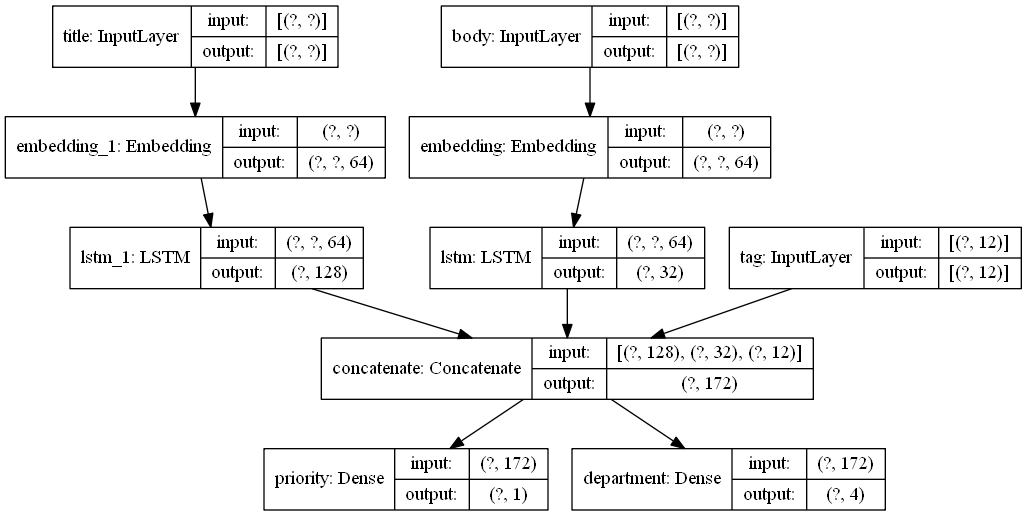

In [15]:
# Super parameters
num_words = 2000
num_tags = 12
num_departments = 4

# inputs
body_input = keras.Input(shape=(None,), name='body')
title_input = keras.Input(shape=(None, ), name='title')
tag_input = keras.Input(shape=(num_tags, ), name='tag')

# Embedded layers
body_feat = layers.Embedding(num_words, 64)(body_input)
title_feat = layers.Embedding(num_words, 64)(title_input)

# Feature extraction layers
body_feat = layers.LSTM(32)(body_feat)
title_feat = layers.LSTM(128)(title_feat)
features = layers.concatenate([title_feat, body_feat, tag_input])

# Classifying layers
priority_pred = layers.Dense(1, activation='sigmoid', name='priority')(features)
department_pred = layers.Dense(num_departments, activation='softmax', name='department')(features)

# Construct a model
model = keras.Model(inputs=[body_input, title_input, tag_input],
                    outputs=[priority_pred, department_pred])
model.summary()
keras.utils.plot_model(model, 'multi_model.png', show_shapes=True)

In [17]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3), loss={'priority':'binary_crossentropy', 'department':'categorical_crossentropy'},loss_weights=[1., 0.2])


In [18]:
import numpy as np
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tag_data = np.random.randint(2, size=(1280, num_tags)).astype('float32')

priority_label = np.random.random(size=(1280, 1))
department_label = np.random.randint(2, size=(1280, num_departments))

In [19]:
history = model.fit(
    {'title':title_data, 
     'body':body_data,
     'tag':tag_data},
    {'priority': priority_label,
     'department':department_label},
    batch_size=32,
    epochs=5
)



Train on 1280 samples
Epoch 1/5
1280/1280 [==============================] - 8s 7ms/sample - loss: 1.3149 - priority_loss: 0.7045 - department_loss: 3.052
Epoch 2/5
1280/1280 [==============================] - 1s 912us/sample - loss: 1.3073 - priority_loss: 0.7023 - department_loss: 3.02
Epoch 3/5
1280/1280 [==============================] - 1s 647us/sample - loss: 1.2976 - priority_loss: 0.7027 - department_loss: 2.97
Epoch 4/5
1280/1280 [==============================] - 1s 642us/sample - loss: 1.2786 - priority_loss: 0.7008 - department_loss: 2.88
Epoch 5/5
1280/1280 [==============================] - 1s 580us/sample - loss: 1.2675 - priority_loss: 0.7000 - department_loss: 2.837


### 3.2 Small Residual Network

Model: "small_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 28, 28, 64)   18496       conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_12[0][0]                  
_______________________________________________________________________________________

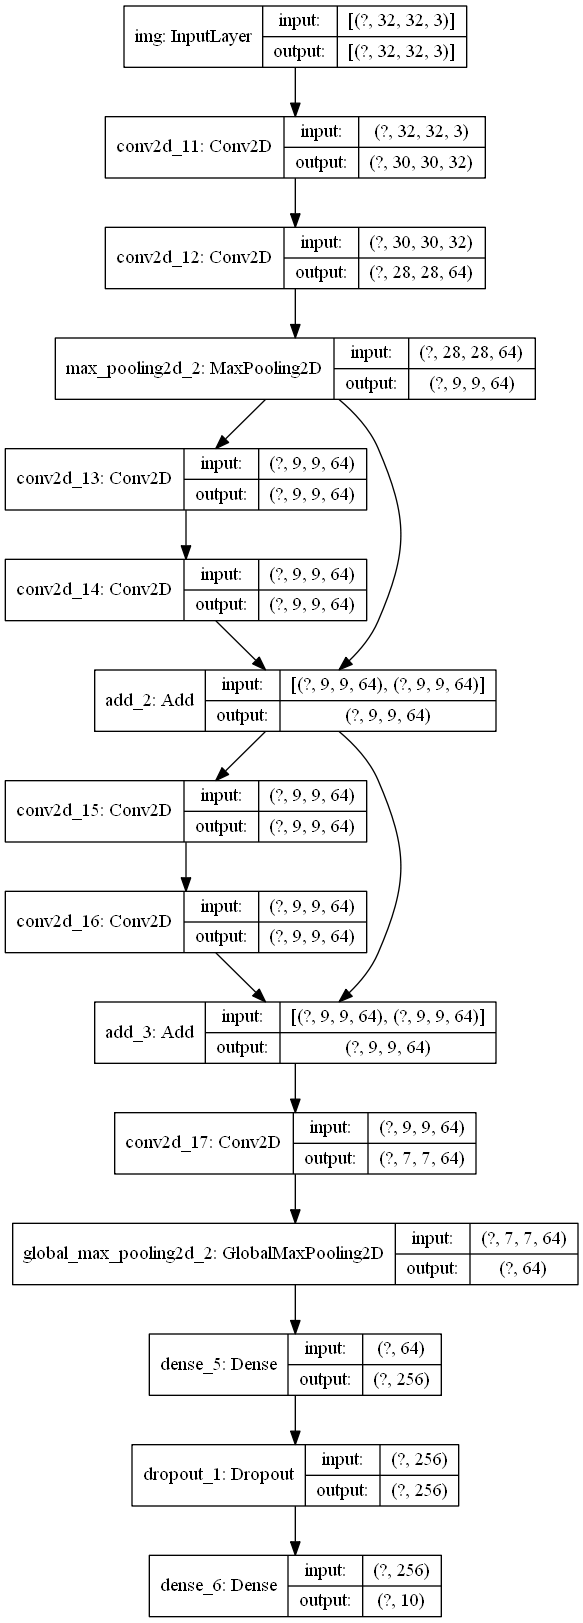

In [31]:
inputs = keras.Input(shape=(32,32,3), name='img')
h1 = layers.Conv2D(32, 3, activation='relu')(inputs)
h1 = layers.Conv2D(64,3,activation='relu')(h1)
block1_out = layers.MaxPooling2D(3)(h1)

h2 = layers.Conv2D(64, 3, activation='relu', padding='same')(block1_out)
h2 = layers.Conv2D(64, 3, activation='relu', padding='same')(h2)
block2_out= layers.add([h2, block1_out])

h3 = layers.Conv2D(64, 3, activation='relu', padding='same')(block2_out)
h3 = layers.Conv2D(64, 3, activation='relu', padding='same')(h3)
block3_out = layers.add([h3, block2_out])

h4 = layers.Conv2D(64, 3, activation='relu')(block3_out)
h4 = layers.GlobalMaxPool2D()(h4)
h4 = layers.Dense(256, activation='relu')(h4)
h4 = layers.Dropout(0.5)(h4)
outputs = layers.Dense(10, activation='softmax')(h4)

model = keras.Model(inputs=inputs, outputs=outputs, name='small_resnet')
model.summary()
keras.utils.plot_model(model, 'small_resnet_model.png', show_shapes=True)

In [26]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()


170500096/170498071 [==============================] - 3095s 18us/st - ETA: 12:2 - ETA: 1


In [27]:
x_train  =  x_train.astype('float32') / 255
x_test = x_test.astype('float32')/255

In [28]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [32]:
model.compile(optimizer = keras.optimizers.RMSprop(1e-3), loss=keras.losses.categorical_crossentropy, metrics=['acc'])

In [33]:
model.fit(x_train, y_train, batch_size=64, epochs=1, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 23s 585us/sample - loss: 1.8884 - acc: 0.2975 - val_loss: 1.9444 - val_acc: 0.32 - ETA: 1s - loss: 1.9050 - acc: 0.291


## 4. Shared network

In [35]:
share_embedding = layers.Embedding(1000, 64)
input1 = keras.Input(shape=(None,), dtype='int32')
input2 = keras.Input(shape=(None,), dtype='int32')

feat1 = share_embedding(input1)
feat2 = share_embedding(input2)

## 5. Use existed model

In [2]:
from tensorflow.keras.applications import VGG16


In [3]:
vgg16 = VGG16()


In [ ]:
feature_list = [layer.output for layer in vgg16.layers]
feat_ext_model = keras.Model(inputs=vgg16.input, outputs=feature_list)
img = np.random.random((1, 224, 224, 3).astype('float32'))
ext_features = feat_ext_model(img)


## Customize layers

In [4]:
class MyDense(layers.Layer):
    def __init__(self, units=32):
        super(MyDense, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal',trainable=True)
        self.b = self.add_weight(shape=(self.units, ), initializer='random_normal', trainable=True)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    def get_config(self):
        return {'units':self.units}
    
inputs = keras.Input((4, ))
outputs = MyDense(10)(inputs)
model = keras.Model(inputs, outputs)
config = model.get_config()
new_model = keras.Model.from_config(config, custom_objects={'MyDense':MyDense})

In [10]:
time_step = 10
batch_size = 32
hidden_dim = 32
inputs_dim = 5

class MyRNN(layers.Layer):
    def __init__(self):
        super(MyRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.projection1 = layers.Dense(units=hidden_dim, activation='relu')
        self.projection2 = layers.Dense(units=hidden_dim, activation='relu')
        self.classifier = layers.Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        out = []
        states = tf.zeros(shape=[inputs.shape[0], self.hidden_dim])
        for t in range(inputs.shape[1]):
            x = inputs[:,t,:]
            h = self.projection1(x)
            y = h + self.projection2(states)
            states = y
            out.append(y)
            
        features = tf.stack(out, axis=1)
        print(features.shape)
        return self.classifier(features)
    
inputs = keras.Input(batch_shape=(batch_size, time_step, inputs_dim))
x = layers.Conv1D(32, 3)(inputs)
print(x.shape)
outputs = MyRNN()(x)
model = keras.Model(inputs, outputs)


rnn_model = MyRNN()
_ = rnn_model(tf.zeros((1, 10, 5)))

(32, 8, 32)
(32, 8, 32)
(1, 10, 32)


Simpe CNN

Model: "small_resnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               1327360   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

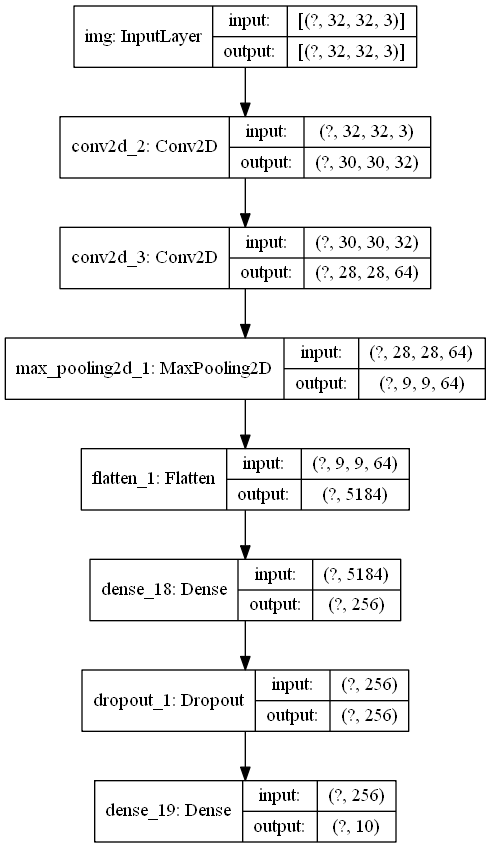

In [13]:
inputs = keras.Input(shape=(32,32,3), name='img')
h1 = layers.Conv2D(32, 3, activation='relu')(inputs)
h2 = layers.Conv2D(64, 3, activation='relu')(h1)
h3 = layers.MaxPooling2D(3)(h2)
h3 = layers.Flatten()(h3)
h4 = layers.Dense(256, activation='relu')(h3)
h4 = layers.Dropout(0.5)(h4)
outputs = layers.Dense(10, activation='softmax')(h4)

model = keras.Model(inputs, outputs, name='small_resnet')
model.summary()
keras.utils.plot_model(model, 'small_resnet_model.png', show_shapes=True)

In [14]:
keras.layers.GlobalMaxPool1D
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = y_train.astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss='categorical_crossentropy',
             metrics=['acc'])
model.fit(x_train, y_train,
         batch_size=64,
         epochs=1,
         validation_split=0.2)

#model.predict(x_test, batch_size=32)

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 21s 523us/sample - loss: 1.5742 - acc: 0.4383 - val_loss: 1.2966 - val_acc: 0.5521
